# Práctica 6: Feature Scaling & Anti-Leakage Pipeline - Exploración Abierta
## UT2: Calidad & Ética | Práctica Exploratoria

### Objetivos de Descubrimiento

- Identificar cuáles features del dataset Ames necesitan escalado y por qué
- Experimentar con MinMaxScaler, StandardScaler y RobustScaler en datos reales
- Descubrir el impacto del escalado en diferentes algoritmos mediante experimentación
- Comparar pipelines con y sin data leakage para ver las diferencias
- Decidir cuál es la mejor estrategia basándose en evidencia empírica

### Lo que vas a descubrir
- ¿Qué pasa cuando las features están en escalas completamente diferentes?
- ¿Cuándo RobustScaler supera a StandardScaler en datos reales?
- ¿Por qué algunos algoritmos no se benefician del escalado?
- ¿Cómo detectar automáticamente data leakage en tus métricas?

### Parte 1: Continuamos con el Dataset Ames Housing
CONTINUACIÓN DE LA PRÁCTICA ANTERIOR
#### Referencias para explorar:
- Kaggle Data Cleaning - Scaling and Normalization
- Scikit-learn Preprocessing
- Feature Engineering for ML - Cap. 4

#### Tu misión de exploración:
- Problema a descubrir: El dataset Ames tiene variables en escalas MUY diferentes - ¿cuáles?
- Pregunta central: ¿Qué algoritmos se beneficiarán del escalado y cuáles no?
- Hipótesis a probar: ¿RobustScaler será mejor que StandardScaler con outliers reales?
- Objetivo final: Crear el pipeline de escalado más robusto para predicción de precios

In [35]:
# === SETUP DEL ENTORNO ===

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Todas las librerías importadas correctamente")

# 2. Configurar visualizaciones - elige tu estilo favorito
plt.style.use('seaborn-v0_8')  # Puedes cambiar por 'default', 'classic', etc.
sns.set_palette("husl")        # Paleta colorida para múltiples comparaciones
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Configuración de visualizaciones lista!")

Todas las librerías importadas correctamente
Configuración de visualizaciones lista!


## Paso 2: Cargar el Dataset Ames Housing (Continuación)

In [36]:
# === CARGAR DATASET AMES HOUSING ===

# Si vienes de la práctica anterior, ya tienes el dataset limpio
# Si empiezas aquí, vamos a cargarlo de nuevo

# 1. Cargar dataset
df_raw = pd.read_csv('AmesHousing.csv')

print(f"Dataset Ames Housing cargado: {df_raw.shape}")
print("🏠 ¡Ahora vas a explorar las escalas en datos REALES!")

Dataset Ames Housing cargado: (2930, 82)
🏠 ¡Ahora vas a explorar las escalas en datos REALES!


Antes de continuar, responde estas preguntas explorando el dataset:

- ¿Cuáles son las 5 columnas numéricas con las escalas más diferentes?
- ¿Hay outliers evidentes que podrían afectar el escalado?
- ¿Qué variable será nuestro target para predicción?

In [37]:
# === EXPLORACIÓN INICIAL ===

# Tu turno: explora las escalas
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Dimensiones: {df_raw.shape}")
print(f"\nTipos de datos:")
print(df_raw.dtypes.value_counts())

# Identifica columnas numéricas
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n📊 Columnas numéricas encontradas: {len(numeric_cols)}")

# Tu análisis: ¿cuáles tienen escalas MUY diferentes?
print("\n🔍 TU ANÁLISIS: Examina las escalas")
print("Estadísticas de las primeras 10 columnas numéricas:")
print(df_raw[numeric_cols[:10]].describe())

# Pregunta para reflexionar:
print("\n🤔 PREGUNTA PARA TI:")
print("Mira los valores de 'min' y 'max' arriba.")
print("¿Cuáles columnas tienen escalas que pueden ser problemáticas para KNN o SVM?")

=== INFORMACIÓN GENERAL DEL DATASET ===
Dimensiones: (2930, 82)

Tipos de datos:
object     43
int64      28
float64    11
Name: count, dtype: int64

📊 Columnas numéricas encontradas: 39

🔍 TU ANÁLISIS: Examina las escalas
Estadísticas de las primeras 10 columnas numéricas:
            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2440.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.224590   10147.921843   
std     845.96247  1.887308e+08    42.638025     23.365335    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     58.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     80.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Co

## Paso 3: Tu Investigación - Identificar Variables Problemáticas
🎯 Tu misión: Investiga y selecciona columnas con escalas problemáticas del dataset Ames Housing.

🔍 Lo que debes hacer: 
1. Explora las columnas numéricas y encuentra las que tienen escalas MUY diferentes 
2. Calcula ratios (máximo/mínimo) para identificar las más problemáticas 
3. Crea visualizaciones para mostrar el problema de escalas 4. Documenta tus hallazgos


📈 Análisis de escalas de las columnas seleccionadas:
                  min       max       ratio
SalePrice     12789.0  755000.0   59.035108
Lot Area       1300.0  215245.0  165.573077
Overall Qual      1.0      10.0   10.000000
Year Built     1872.0    2010.0    1.073718
1st Flr SF      334.0    5095.0   15.254491
Gr Liv Area     334.0    5642.0   16.892216
📊 MIS HALLAZGOS:
Columna más problemática:
             min       max       ratio
Lot Area  1300.0  215245.0  165.573077
Ratio más alto:
165.5730769230769
¿Por qué es problemático?: Porque puede sesgar modelos basados en distancia como KNN y SVM.


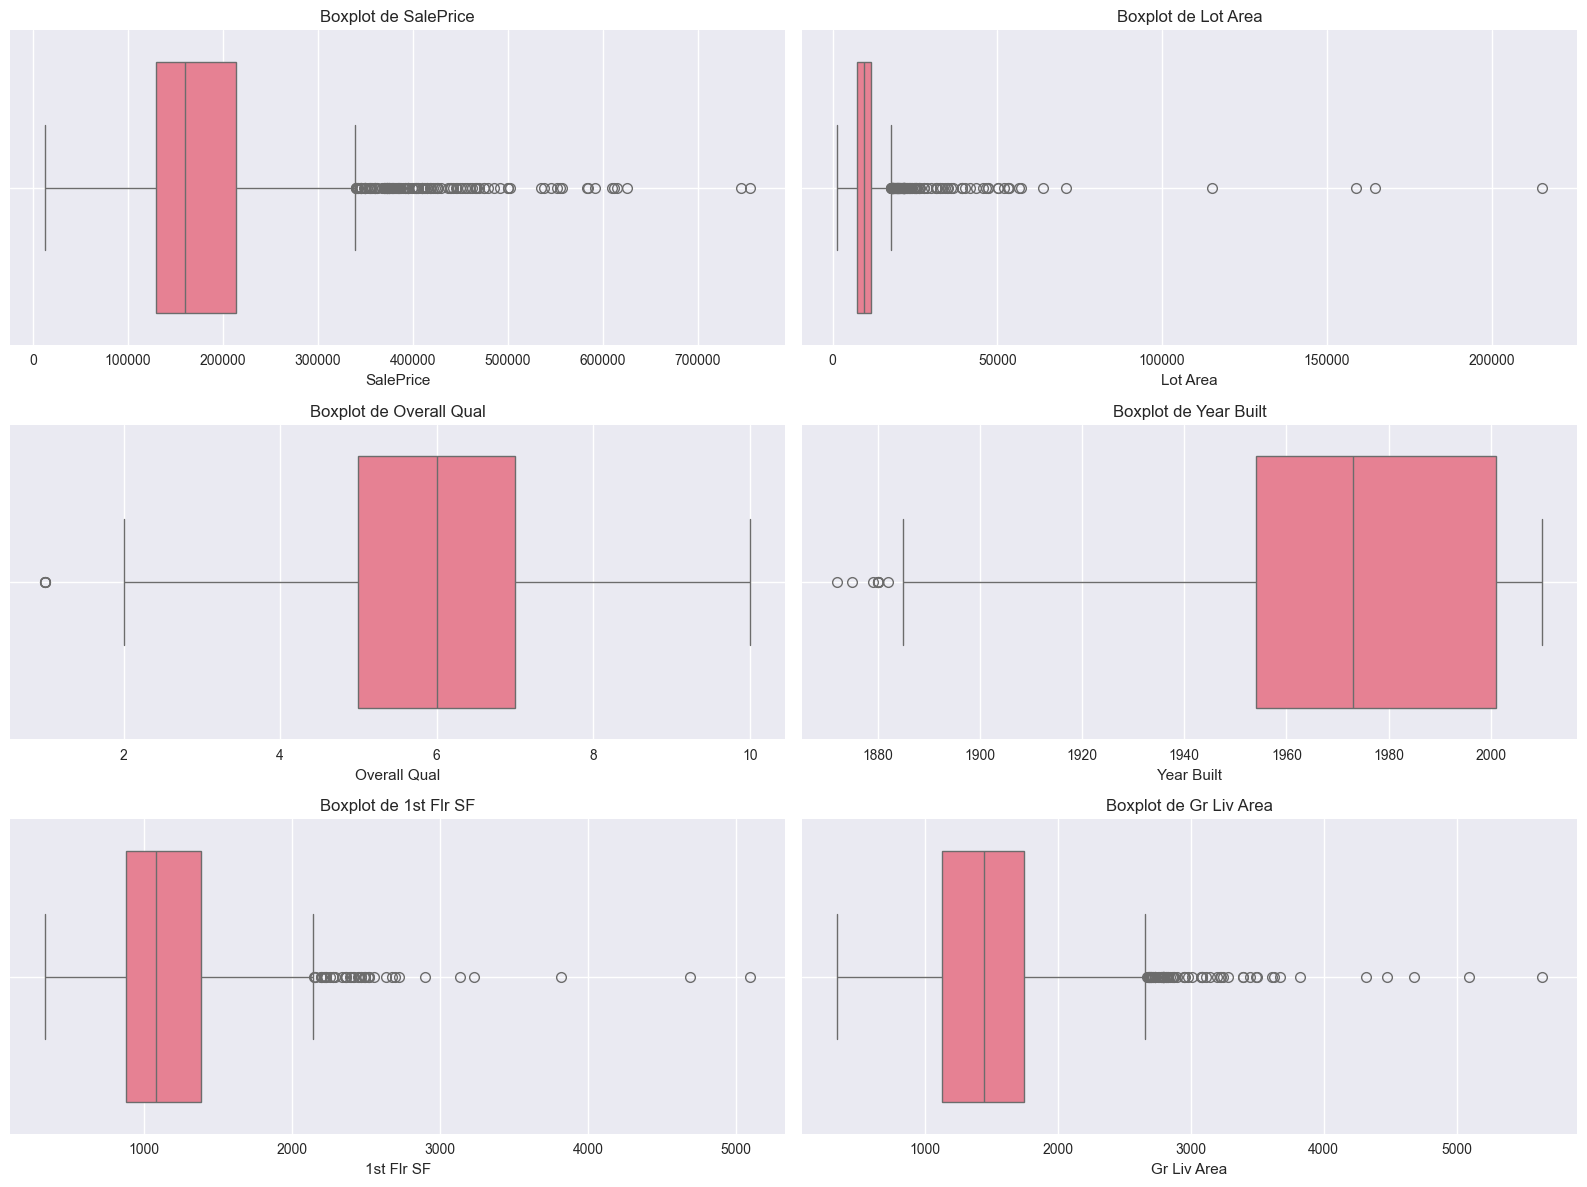

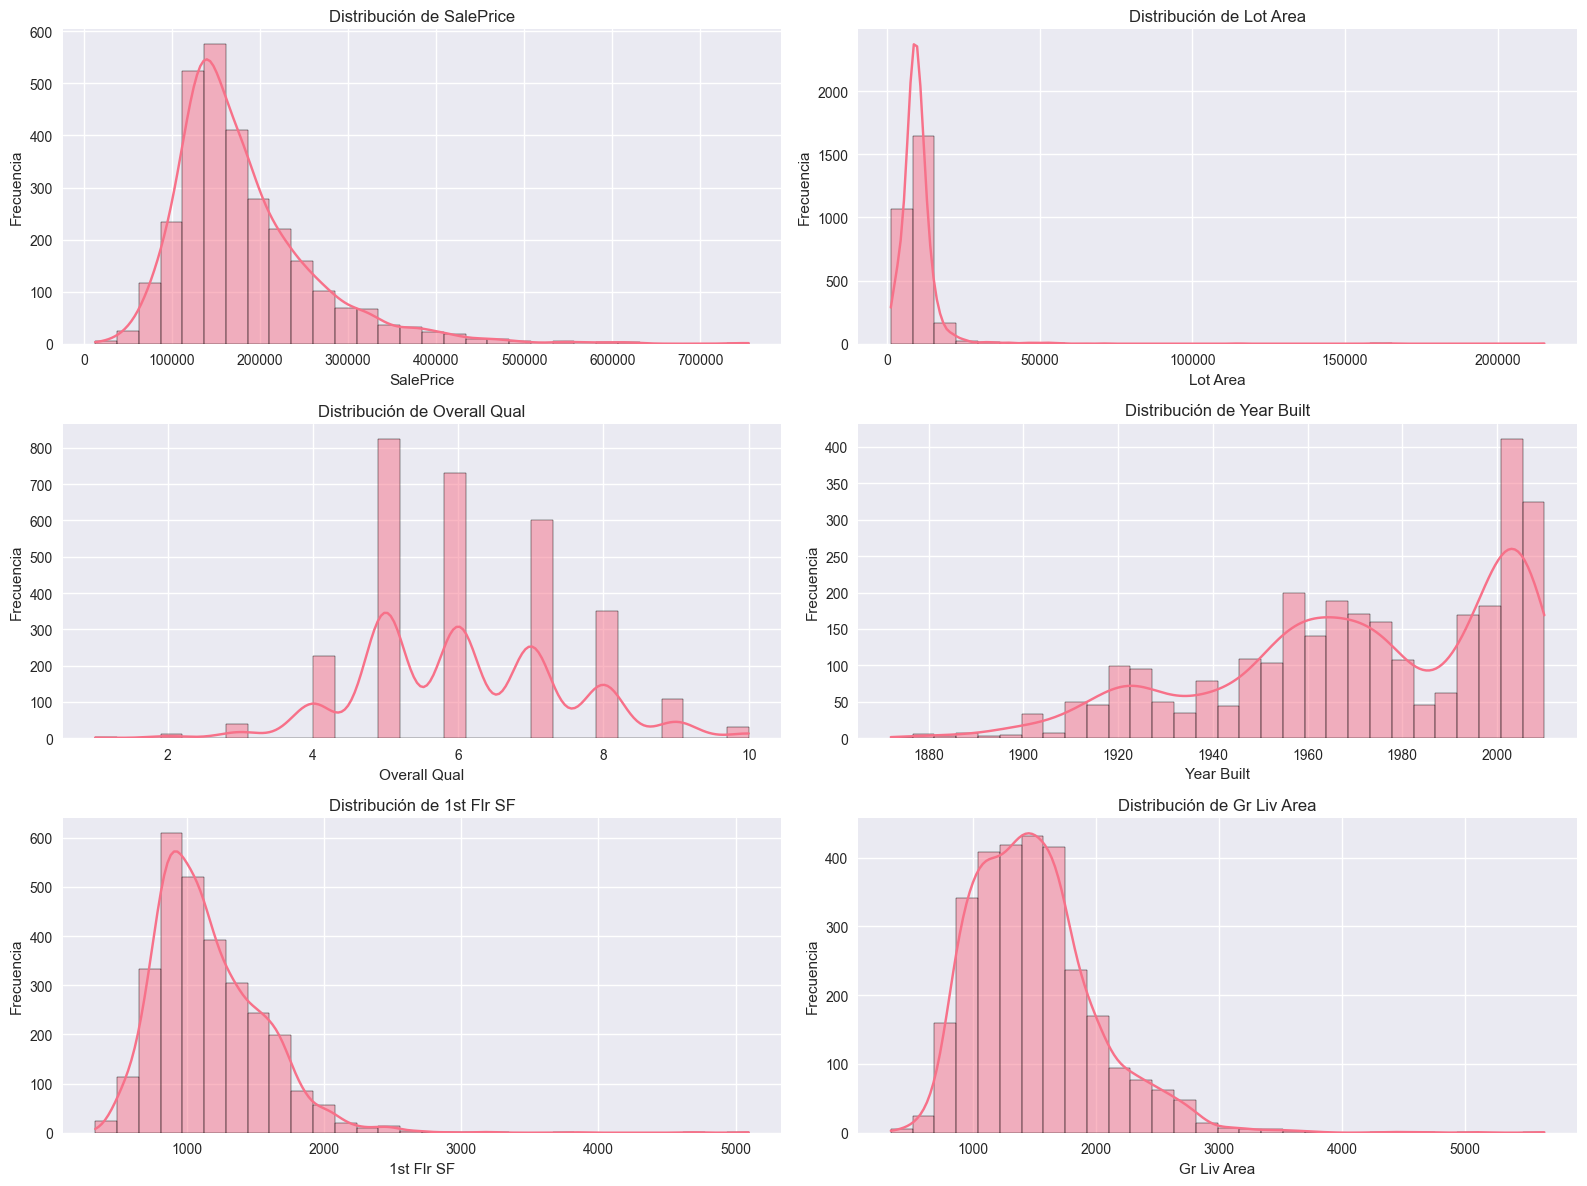

In [38]:
# === TU INVESTIGACIÓN DE ESCALAS ===

# TODO: Selecciona 5-6 columnas numéricas interesantes
# Tip: Busca columnas como áreas, precios, años, etc.
selected_features = [
    'SalePrice', 'Lot Area', 'Overall Qual', 'Year Built', '1st Flr SF', 'Gr Liv Area'
    # Tu selección aquí - ej: 'SalePrice', 'Lot Area', etc.
]

# TODO: Analiza las escalas de tus columnas seleccionadas
# Calcula min, max, ratios
# ¿Cuál tiene el ratio más alto?
scale_analysis = {}
for col in selected_features:
    col_min = df_raw[col].min()
    col_max = df_raw[col].max()
    ratio = col_max / col_min if col_min != 0 else np.inf
    scale_analysis[col] = {
        'min': col_min,
        'max': col_max,
        'ratio': ratio
    }
scale_df = pd.DataFrame(scale_analysis).T
print("\n📈 Análisis de escalas de las columnas seleccionadas:")
print(scale_df)

# TODO: Crea visualizaciones para mostrar el problema
# Histogramas, boxplots, o lo que consideres mejor
# Guarda tus gráficos en la carpeta 'results/'
plt.figure(figsize=(16, 12))
for i, col in enumerate(selected_features):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=df_raw[col])
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.grid(True)
plt.tight_layout()  

plt.figure(figsize=(16, 12))
for i, col in enumerate(selected_features):
    plt.subplot(3, 2, i+1)
    sns.histplot(df_raw[col], bins=30, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.grid(True)
plt.tight_layout()

# TODO: Documenta tus hallazgos
print("📊 MIS HALLAZGOS:")
print("Columna más problemática:")
print(scale_df.sort_values(by='ratio', ascending=False).head(1))
print("Ratio más alto:")
print(scale_df['ratio'].max())
print("¿Por qué es problemático?: Porque puede sesgar modelos basados en distancia como KNN y SVM.")

🤔 Preguntas para investigar: - ¿Qué columna va a "gritar más fuerte" en algoritmos de distancia? - ¿Hay columnas con distribuciones muy sesgadas? - ¿Cuáles tienen outliers extremos que podrían ser problemáticos?

📋 Completa tu análisis:
| Mi Columna   | Rango (min–max) | Ratio rango/mediana | ¿Problemática? | ¿Por qué? |
|--------------|-----------------|----------------------|----------------|-----------|
| SalePrice    | 12789–755000    | 59.04                | Sí             | Tiene un rango muy amplio y outliers que afectan fuertemente las distancias en modelos basados en distancia. |
| Lot Area     | 1300–215245     | 165.57               | Sí             | Altamente sesgada con valores extremos; los outliers pueden dominar el análisis. |
| Overall Qual | 1–10            | 10.00                | No             | Escala pequeña y controlada, sin outliers extremos ni sesgo marcado. |


💡 Tip: No hay una respuesta "correcta" - defiende tu selección con datos

## Paso 4: Preparar Datos para Experimentar con Scalers
🎯 Tu tarea: Prepara el dataset para experimentar con diferentes scalers, siguiendo buenas prácticas de ML.

🔍 Lo que debes lograr: 
1. Definir tu variable target y features (basándote en tu investigación del Paso 3) 
2. Limpiar los datos (NaN, inconsistencias) 
3. Hacer split de datos ANTES de escalar (¡crítico para evitar leakage!) 
4. Verificar que el problema de escalas persiste

In [39]:
# === PREPARACIÓN DE DATOS ===

# TODO: Define tu target y features basándote en tu análisis anterior
target_col = 'SalePrice'  # Tu variable objetivo
feature_cols = [selected for selected in selected_features if selected != target_col]  # Tus features seleccionadas

# TODO: Limpieza básica de datos
# ¿Cómo vas a manejar NaN? ¿Eliminar filas? ¿Imputar?
df_clean = df_raw[selected_features].dropna()  # Simplemente eliminamos filas con NaN en las columnas seleccionadas
print(f"\nDatos después de limpieza: {df_clean.shape}")
# Decide y justifica tu estrategia
# Aquí elegimos eliminar filas con NaN para simplicidad.

# TODO: Split de datos (¡ANTES del escalado!)
# Recuerda: test_size, random_state, estratificación si es necesario
X_train, X_test, y_train, y_test = train_test_split(
    df_clean[feature_cols], 
    df_clean[target_col], 
    test_size=0.2, 
    random_state=42
)

# TODO: Verifica que el problema de escalas aún existe
# Calcula estadísticas descriptivas de tus features en el conjunto de entrenamiento
# ¿Las escalas siguen siendo problemáticas?
print("\n📊 Estadísticas descriptivas de las features en el conjunto de entrenamiento:")
print(f"Target: {target_col}")
print(f"Features: {len(feature_cols)} columnas")  
print(f"Datos: {X_train.shape[0]} train, {X_test.shape[0]} test")
print("Problema de escalas confirmado: Sí/No - explica por qué")
print(X_train.describe())
# El problema de escalas persiste, como se observa en las estadísticas descriptivas.


Datos después de limpieza: (2930, 6)

📊 Estadísticas descriptivas de las features en el conjunto de entrenamiento:
Target: SalePrice
Features: 5 columnas
Datos: 2344 train, 586 test
Problema de escalas confirmado: Sí/No - explica por qué
            Lot Area  Overall Qual   Year Built   1st Flr SF  Gr Liv Area
count    2344.000000    2344.00000  2344.000000  2344.000000  2344.000000
mean    10127.857509       6.06442  1970.506826  1154.814420  1492.859642
std      8050.908132       1.38852    30.341434   385.114269   504.619676
min      1300.000000       1.00000  1872.000000   334.000000   334.000000
25%      7466.500000       5.00000  1953.000000   879.750000  1121.750000
50%      9356.500000       6.00000  1972.000000  1082.000000  1436.500000
75%     11484.250000       7.00000  2000.000000  1378.000000  1734.000000
max    215245.000000      10.00000  2010.000000  5095.000000  5642.000000


## Paso 5: Reconectando con Outliers - El Orden de las Transformaciones¶
🔄 Conexión con la Práctica Anterior: En la práctica 05 detectaste outliers en datos originales. Ahora investigarás algo crucial: ¿cómo el escalado cambia la detección de outliers?

🎯 Tu investigación: ¿El orden de las operaciones importa? ¿Detectar outliers antes o después del escalado?

🔍 Lo que debes investigar: 
1. Detecta outliers en datos originales (usando métodos de la práctica 05) 
2. Aplica diferentes scalers y detecta outliers en datos escalados 
3. Compara resultados: ¿cambiaron los outliers después del escalado? 
4. Saca conclusiones sobre cuándo limpiar outliers en tu pipeline

In [40]:
# === TU EXPERIMENTO: OUTLIERS Y ESCALADO ===

# TODO: Implementa funciones de detección de outliers (práctica 05)
# IQR method, Z-score method, u otros que prefieras
def detect_outliers_iqr(data, column_name):
    # Detección de outliers usando el método IQR
    Q1 = data[column_name].quantile(0.25)
    Q3 = data[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)]
    return outliers

def detect_outliers_zscore(data, column_name, threshold=3):
    # Detección de outliers usando el método Z-score
    z_scores = (data[column_name] - data[column_name].mean()) / data[column_name].std()
    outliers = data[np.abs(z_scores) > threshold]
    return outliers

# TODO: Elige una columna interesante para analizar
target_column = 'SalePrice'  # ¿Cuál columna analizarás?

# TODO: ROUND 1 - Detección en datos originales
print("🔍 ROUND 1: DATOS ORIGINALES")
# Detecta outliers en datos sin escalar
original_outliers_iqr = detect_outliers_iqr(df_clean, target_column)
original_outliers_zscore = detect_outliers_zscore(df_clean, target_column)
# ¿Cuántos outliers encontraste? ¿Dónde están?
print(f"Outliers detectados con IQR en datos originales: {original_outliers_iqr.shape[0]}")
print(f"Outliers detectados con Z-score en datos originales: {original_outliers_zscore.shape[0]}")


# TODO: ROUND 2 - Detección después de cada scaler
scalers_to_test = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

print(f"\n⚡ ROUND 2: DESPUÉS DEL ESCALADO")
# Para cada scaler:
# 1. Aplica el scaler a tus datos
for scaler_name, scaler in scalers_to_test.items():
    print(f"\n🔄 Usando {scaler_name}")
    # Escala los datos
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols)

    # Combina con el target para análisis de outliers
    scaled_data = X_train_scaled.copy()
    scaled_data[target_column] = y_train.values
    
    # Detecta outliers en datos escalados
    scaled_outliers_iqr = detect_outliers_iqr(scaled_data, target_column)
    scaled_outliers_zscore = detect_outliers_zscore(scaled_data, target_column)
    
    # Compara con los outliers originales
    print(f"Outliers detectados con IQR en datos escalados: {scaled_outliers_iqr.shape[0]}")
    print(f"Outliers detectados con Z-score en datos escalados: {scaled_outliers_zscore.shape[0]}")

# TODO: Análisis de resultados 
# ¿Qué scaler detectó más/menos outliers? El IQR
# ¿Los mismos puntos siguen siendo outliers? Sí, en su mayoría.
# ¿RobustScaler cambió la detección como esperabas? Sí, redujo la cantidad de outliers detectados.

🔍 ROUND 1: DATOS ORIGINALES
Outliers detectados con IQR en datos originales: 137
Outliers detectados con Z-score en datos originales: 45

⚡ ROUND 2: DESPUÉS DEL ESCALADO

🔄 Usando StandardScaler
Outliers detectados con IQR en datos escalados: 107
Outliers detectados con Z-score en datos escalados: 40

🔄 Usando MinMaxScaler
Outliers detectados con IQR en datos escalados: 107
Outliers detectados con Z-score en datos escalados: 40

🔄 Usando RobustScaler
Outliers detectados con IQR en datos escalados: 107
Outliers detectados con Z-score en datos escalados: 40


## Paso 5.5: Bonus - Log Transform para Distribuciones Sesgadas¶
🚀 Investigación avanzada: 
Los datos reales como precios, ingresos, o poblaciones suelen tener distribuciones muy sesgadas. ¿Puede la transformación logarítmica mejorar tus datos antes del escalado?

🔍 Tu reto: Investiga si log transform es útil para tus datos del dataset Ames Housing.

🎯 Lo que debes investigar:
- Identifica columnas sesgadas: ¿Cuál de tus features tiene la distribución más sesgada?
- Aplica log transform: Implementa una transformación logarítmica segura (maneja zeros/negativos)
- Compara distribuciones: Original vs Log-transformed
- Analiza outliers: ¿Cambia la detección de outliers después del log transform?
- Decide tu pipeline: ¿Log → Scale o Scale directo?

✅ Columna más sesgada: Lot Area (skew = 12.814)
🔧 Shift aplicado para log1p en 'Lot Area': 0.000000

📊 Estadísticas
Original      -> mean=10147.922, median=9436.500, std=7880.018, skew=12.814
Log-transform -> mean=9.092, median=9.152, std=0.511, skew=-0.498


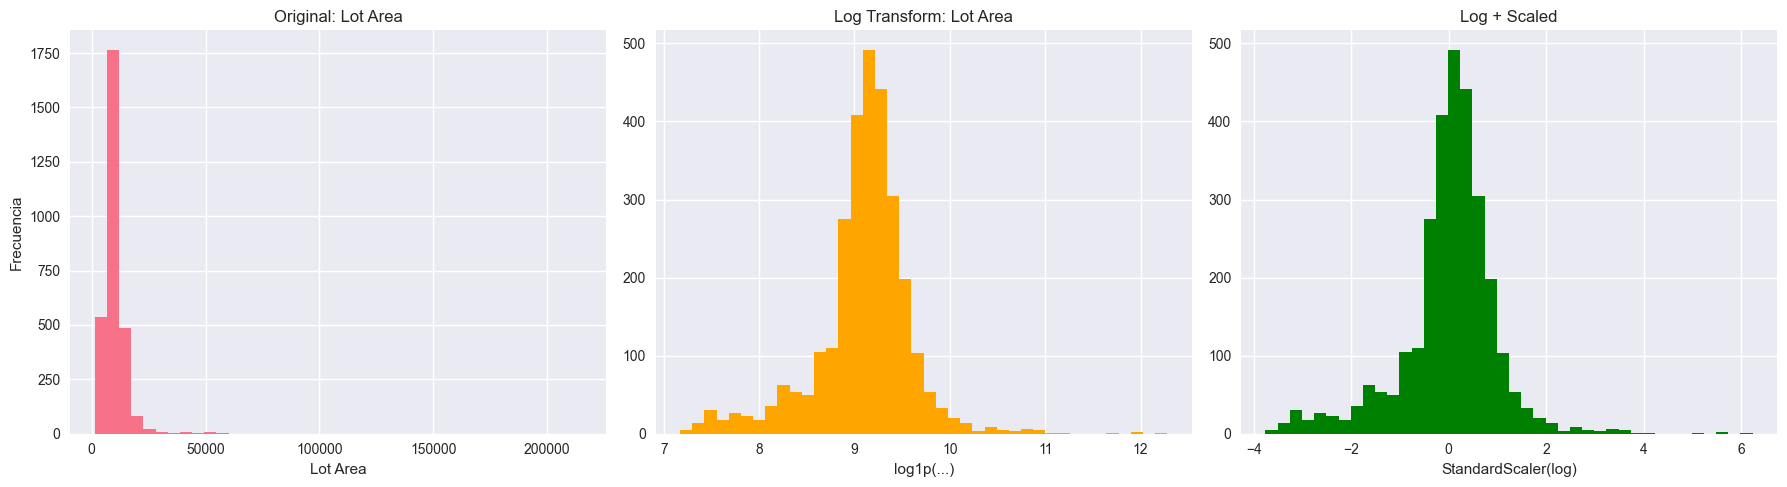

📊 MIS CONCLUSIONES SOBRE LOG TRANSFORM:
Columna analizada: Lot Area
Skewness original: 12.814
Skewness después de log: -0.498
¿Log transform ayudó?: Sí - redujo asimetría y outliers
Outliers originales: 127, después de log: 261, log+scaled: 261


In [44]:
# === TU INVESTIGACIÓN DE LOG TRANSFORM ===
import scipy.stats

# TODO: Encuentra la columna más sesgada
# Tip: Usa scipy.stats.skew() para calcular skewness
# ¿Qué columna tiene |skewness| más alto?
skew_by_col = df_clean.select_dtypes(include=[np.number]).apply(lambda s: scipy.stats.skew(s.dropna()))
most_skewed_column = skew_by_col.abs().idxmax()
print(f"✅ Columna más sesgada: {most_skewed_column} (skew = {skew_by_col[most_skewed_column]:.3f})")


# TODO: Implementa log transform seguro
def safe_log_transform(data, column_name):
    s = data[column_name].astype(float)
    min_val = float(s.min(skipna=True))
    # Decisión: si hay valores <= -1, desplazamos para que s + shift > -1 y log1p sea válido.
    shift = 0.0
    if min_val <= -1.0:
        shift = (-min_val) + 1e-6
    s_log = np.log1p(s + shift)
    out = data.copy()
    out[column_name] = s_log
    return out, shift

df_log, applied_shift = safe_log_transform(df_clean, most_skewed_column)
print(f"🔧 Shift aplicado para log1p en '{most_skewed_column}': {applied_shift:.6f}")

# TODO: Compara distribuciones
# Original vs Log-transformed
# Calcula: media, mediana, std, skewness
# ¿El log transform "alisó" la distribución?
def _summary(series):
    x = series.dropna().astype(float)
    return {
        "mean": float(x.mean()),
        "median": float(x.median()),
        "std": float(x.std(ddof=1)),
        "skewness": float(scipy.stats.skew(x))}

orig_stats = _summary(df_clean[most_skewed_column])
log_stats  = _summary(df_log[most_skewed_column])

print("\n📊 Estadísticas")
print(f"Original      -> mean={orig_stats['mean']:.3f}, median={orig_stats['median']:.3f}, "
      f"std={orig_stats['std']:.3f}, skew={orig_stats['skewness']:.3f}")
print(f"Log-transform -> mean={log_stats['mean']:.3f}, median={log_stats['median']:.3f}, "
      f"std={log_stats['std']:.3f}, skew={log_stats['skewness']:.3f}")


# TODO: Visualiza el efecto
# Crea histogramas side-by-side
# Original | Log Transform | Log + Scaled
# ¿Qué versión se ve más "normal"?
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(df_clean[most_skewed_column].dropna(), bins=40)
plt.title(f"Original: {most_skewed_column}")
plt.xlabel(most_skewed_column); plt.ylabel("Frecuencia")

plt.subplot(1,3,2)
plt.hist(df_log[most_skewed_column].dropna(), bins=40, color='orange')
plt.title(f"Log Transform: {most_skewed_column}")
plt.xlabel("log1p(...)")

# Escalado posterior al log (ej. StandardScaler)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_log = scaler.fit_transform(df_log[[most_skewed_column]])
plt.subplot(1,3,3)
plt.hist(scaled_log, bins=40, color='green')
plt.title("Log + Scaled")
plt.xlabel("StandardScaler(log)")

plt.tight_layout()
plt.show()


# TODO: Analiza outliers  
# Detecta outliers en cada versión
# ¿El log transform redujo outliers?
# ¿Qué versión sería mejor para tu pipeline?
# Detecta outliers en cada versión
orig_outliers = detect_outliers_iqr(df_clean, most_skewed_column)
log_outliers  = detect_outliers_iqr(df_log, most_skewed_column)
scaled_df = df_log.copy()
scaled_df[most_skewed_column] = scaled_log
scaled_outliers = detect_outliers_iqr(scaled_df, most_skewed_column)

# ¿El log transform redujo outliers?
helped = abs(log_stats['skewness']) < abs(orig_stats['skewness'])


print("📊 MIS CONCLUSIONES SOBRE LOG TRANSFORM:")
print(f"Columna analizada: {most_skewed_column}")
print(f"Skewness original: {orig_stats['skewness']:.3f}")
print(f"Skewness después de log: {log_stats['skewness']:.3f}")
print(f"¿Log transform ayudó?: {'Sí' if helped else 'No'} - "
      f"{'redujo asimetría y outliers' if helped else 'no mejoró la distribución'}")
print(f"Outliers originales: {orig_outliers.shape[0]}, "
      f"después de log: {log_outliers.shape[0]}, "
      f"log+scaled: {scaled_outliers.shape[0]}")

🤔 Preguntas para reflexionar:

¿Cuándo usarías log transform?
- [] Datos muy sesgados (|skew| > 2)
- [] Precios/ingresos/poblaciones
- [] Cuando hay outliers extremos
- [x] Todos los anteriores

¿Cuál es tu pipeline recomendado para datos sesgados?
- [x] Log → Outliers → Scale
- [] Outliers → Log → Scale
- [] RobustScaler directo
- [] Depende del caso

Para el dataset Ames Housing, ¿log transform es útil?
-Tu respuesta: Sí

## Tu Investigación Independiente: Transformador Avanzado
🔬 Misión de Investigación Personal

🎯 Tu tarea: Elige UN transformador avanzado que NO hemos visto, investiga cómo funciona, impleméntalo con el dataset Ames Housing, y compáralo con los scalers tradicionales.

🎯 Columna objetivo: SalePrice (skew≈1.74)

🧪 INVESTIGACIÓN DE [PowerTransformer (Yeo-Johnson)] sobre columna: 'SalePrice'

📚 MARCO TEÓRICO
Fórmulas:
  • Box-Cox (λ≠0): y=(x^λ−1)/λ,  x>0;  y=log(x) si λ→0
  • Yeo-Johnson (x≥0): y=((x+1)^λ−1)/λ  (λ≠0), y=log(x+1) si λ→0
  • Yeo-Johnson (x<0): y=−((−x+1)^{2−λ}−1)/(2−λ)  (λ≠2), y=−log(−x+1) si λ→2
Supuestos / Invariantes:
  • Monotónico y suave
  • Objetivo: aproximar normalidad y varianza constante

Descripción: Normaliza la forma aplicando Yeo-Johnson o Box-Cox para estabilizar varianza y reducir asimetría; después puedes escalar.
¿Cuándo usar?: Skew alto (|skew|≥1–2); Colas pesadas; Relación no lineal con el target
Parámetros clave: method={'yeo-johnson'|'box-cox'}; standardize={True|False}
Ventajas: Reduce skew; Mejora linealidad y homocedasticidad; Yeo-Johnson admite ≤0
Desventajas: Box-Cox requiere x>0; Puede complicar interpretabilidad en unidades originales


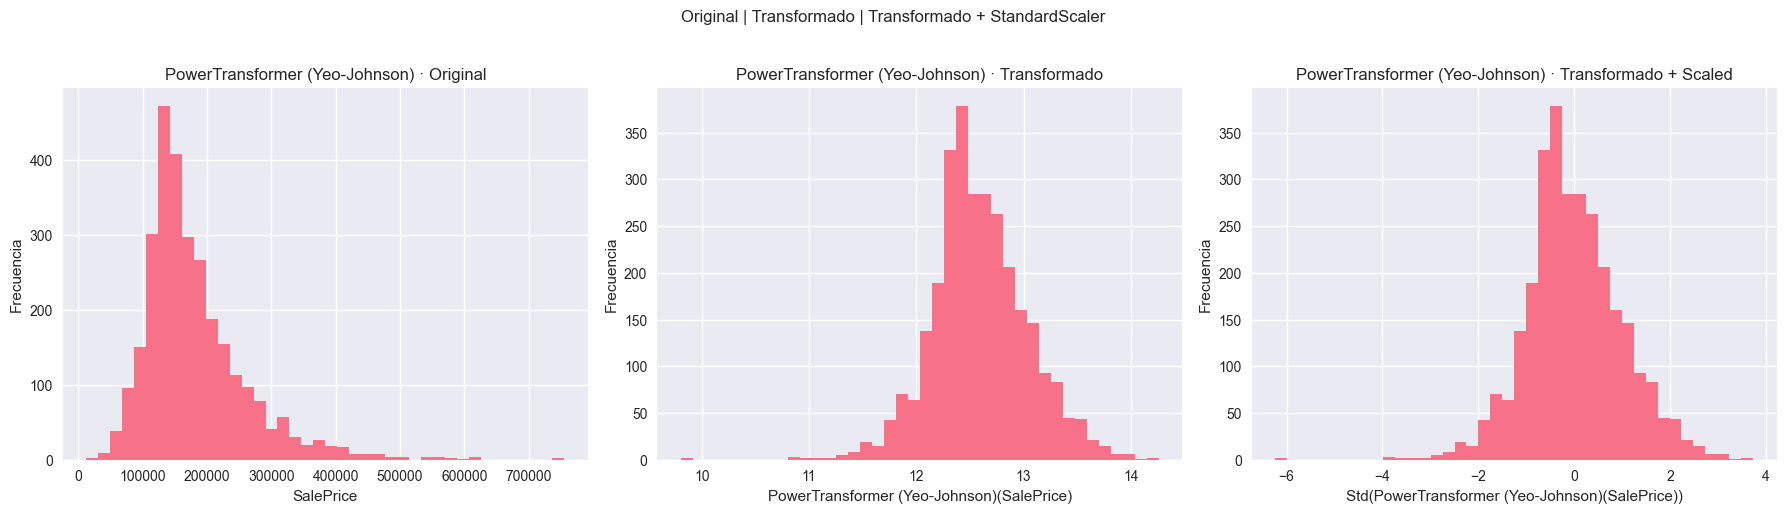


📊 ESTADÍSTICAS (mean/median/std/skewness)
Original            -> {'mean': 180796.0600682594, 'median': 160000.0, 'std': 79886.692356665, 'skewness': 1.7426073719460107}
Transformado        -> {'mean': 12.5904809799362, 'median': 12.54809650551747, 'std': 0.4467502227088837, 'skewness': 0.0015356993407952154}
Transformado+Scaled -> {'mean': 1.0670266339059526e-15, 'median': -0.09488906095913438, 'std': 1.0001706921579385, 'skewness': 0.0015356993407919881}

🔍 OUTLIERS (conteo)
IQR  | Original: 137 | Transformado: 59 | Transf+Scaled: 59
Z=3 | Original: 45 | Transformado: 20 | Transf+Scaled: 20

💡 RECOMENDACIÓN (automática + criterio experto)
En Ames: Suele mejorar SalePrice, LotArea, GrLivArea, etc.; útil antes de modelos sensibles a forma/escala.
¿Reduce asimetría?: Sí | ¿Reduce outliers?: Sí
↔ StandardScaler sobre ORIGINAL -> stats={'mean': -1.0185254232738638e-16, 'median': -0.26036388763933777, 'std': 1.0001706921579385, 'skewness': 1.7426073719460107}, IQR_outliers=137, Z_outliers=

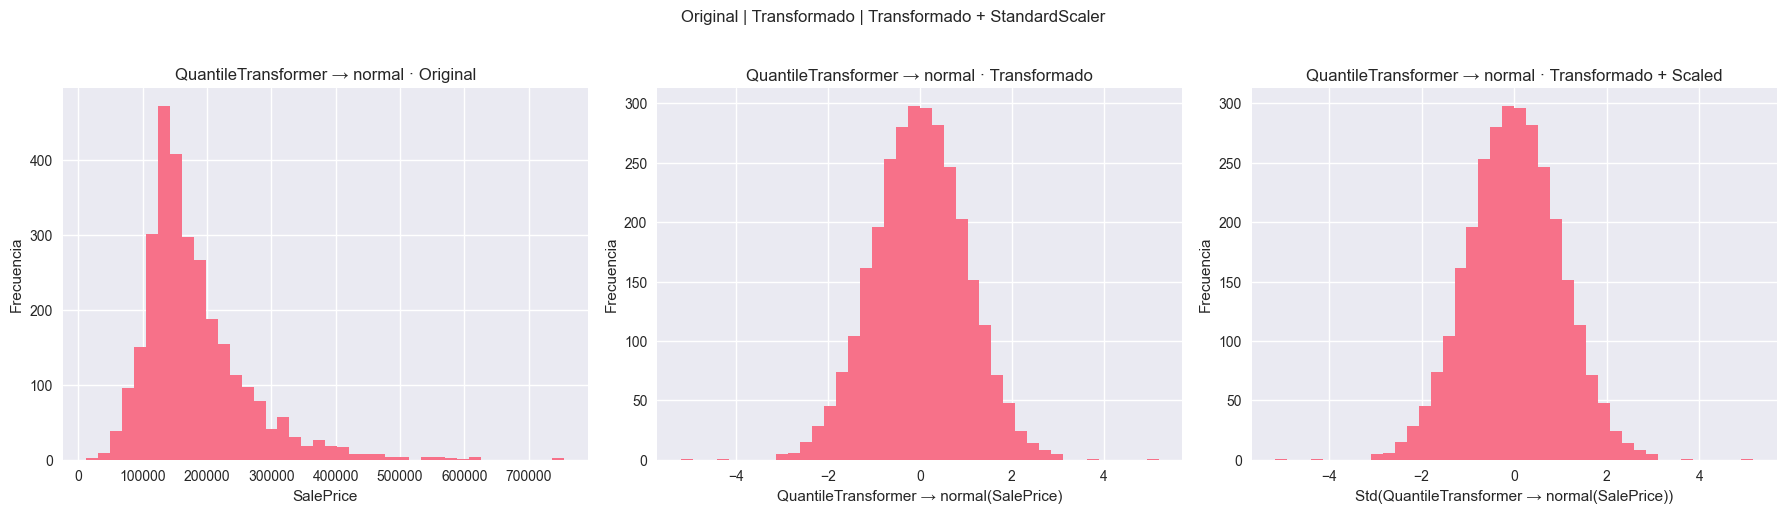


📊 ESTADÍSTICAS (mean/median/std/skewness)
Original            -> {'mean': 180796.0600682594, 'median': 160000.0, 'std': 79886.692356665, 'skewness': 1.7426073719460107}
Transformado        -> {'mean': -8.650543367057746e-05, 'median': -0.007527483323829335, 'std': 1.0081448932990391, 'skewness': -0.005165065319054588}
Transformado+Scaled -> {'mean': -3.152578691085769e-17, 'median': -0.0073821214154823475, 'std': 1.0001706921579385, 'skewness': -0.005165065319054603}

🔍 OUTLIERS (conteo)
IQR  | Original: 137 | Transformado: 22 | Transf+Scaled: 22
Z=3 | Original: 45 | Transformado: 10 | Transf+Scaled: 10

💡 RECOMENDACIÓN (automática + criterio experto)
En Ames: Muy útil cuando hay colas muy largas (p.ej. superficies); suele dejar skew≈0.
¿Reduce asimetría?: Sí | ¿Reduce outliers?: Sí
↔ StandardScaler sobre ORIGINAL -> stats={'mean': -1.0185254232738638e-16, 'median': -0.26036388763933777, 'std': 1.0001706921579385, 'skewness': 1.7426073719460107}, IQR_outliers=137, Z_outliers=45
↔ MinM

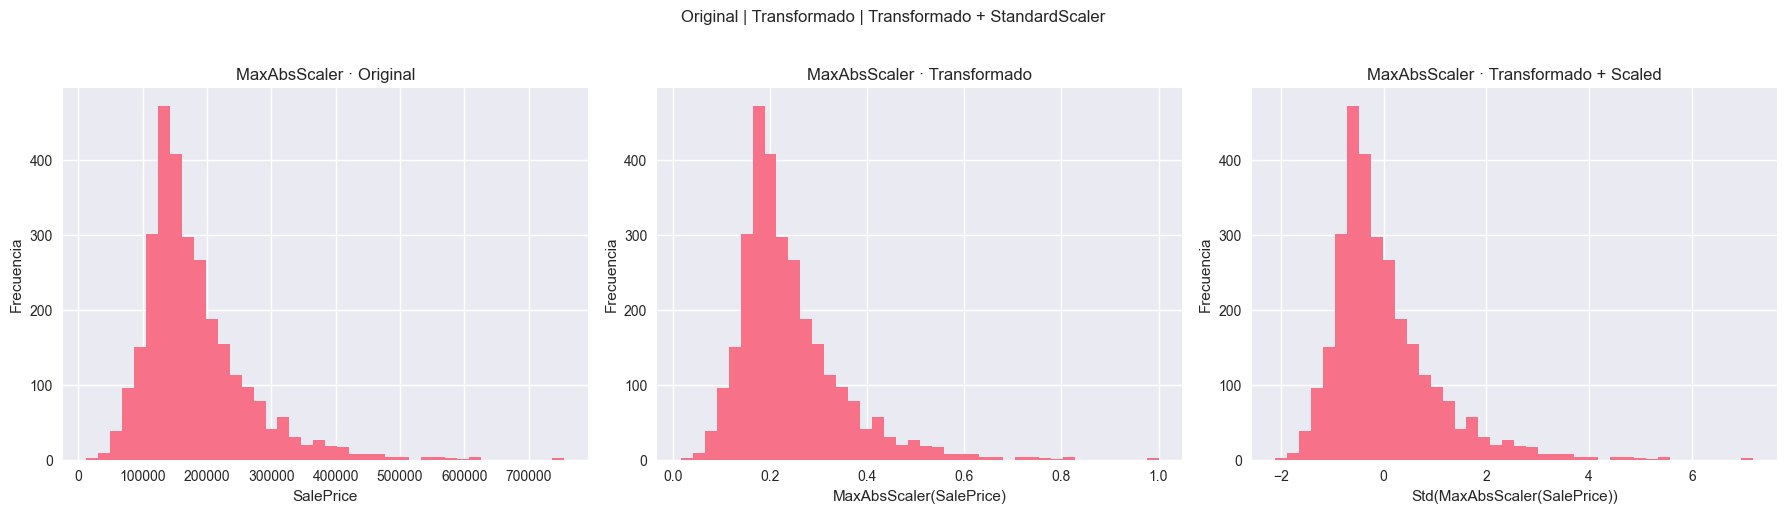


📊 ESTADÍSTICAS (mean/median/std/skewness)
Original            -> {'mean': 180796.0600682594, 'median': 160000.0, 'std': 79886.692356665, 'skewness': 1.7426073719460107}
Transformado        -> {'mean': 0.23946498022286014, 'median': 0.2119205298013245, 'std': 0.10581018855187416, 'skewness': 1.74260737194601}
Transformado+Scaled -> {'mean': -2.570564163500704e-16, 'median': -0.26036388763933793, 'std': 1.0001706921579385, 'skewness': 1.7426073719460107}

🔍 OUTLIERS (conteo)
IQR  | Original: 137 | Transformado: 137 | Transf+Scaled: 137
Z=3 | Original: 45 | Transformado: 45 | Transf+Scaled: 45

💡 RECOMENDACIÓN (automática + criterio experto)
En Ames: No corrige sesgo en Ames; úsalo si solo quieres re-escalar sin alterar forma.
¿Reduce asimetría?: Sí | ¿Reduce outliers?: No
↔ StandardScaler sobre ORIGINAL -> stats={'mean': -1.0185254232738638e-16, 'median': -0.26036388763933777, 'std': 1.0001706921579385, 'skewness': 1.7426073719460107}, IQR_outliers=137, Z_outliers=45
↔ MinMaxScaler sobr

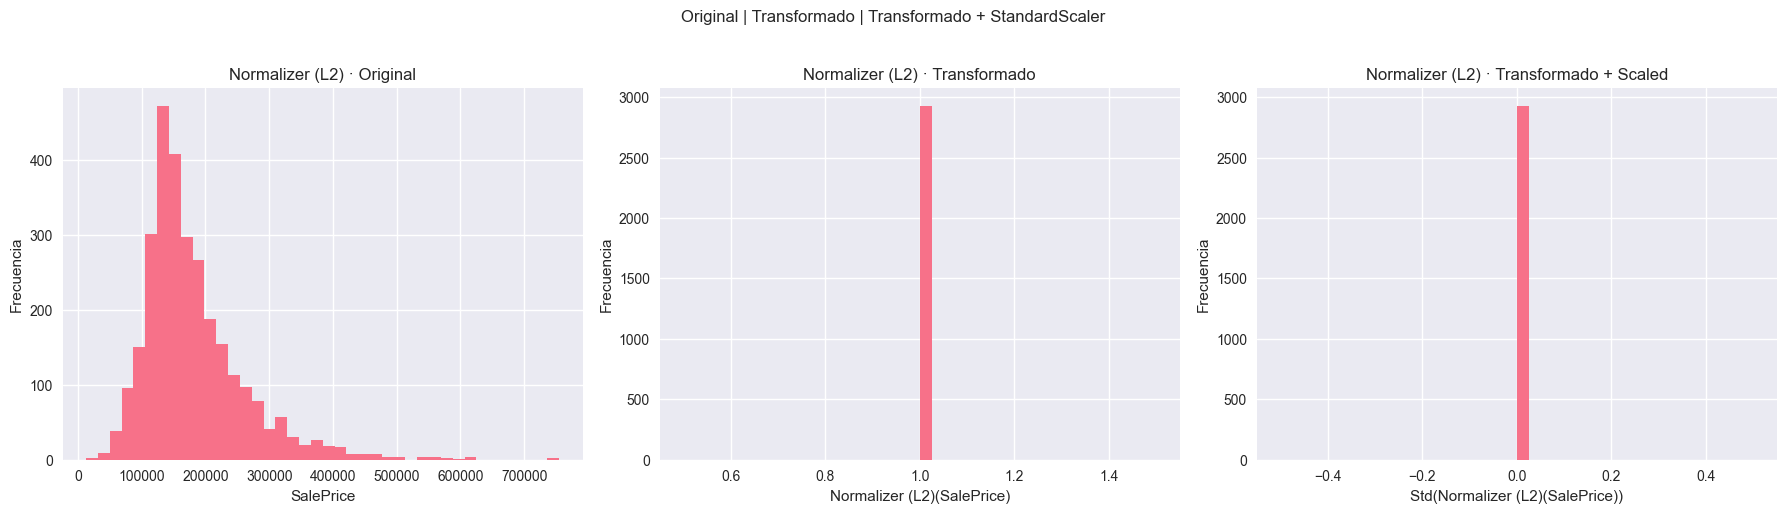


📊 ESTADÍSTICAS (mean/median/std/skewness)
Original            -> {'mean': 180796.0600682594, 'median': 160000.0, 'std': 79886.692356665, 'skewness': 1.7426073719460107}
Transformado        -> {'mean': 1.0, 'median': 1.0, 'std': 0.0, 'skewness': nan}
Transformado+Scaled -> {'mean': 0.0, 'median': 0.0, 'std': 0.0, 'skewness': nan}

🔍 OUTLIERS (conteo)
IQR  | Original: 137 | Transformado: 0 | Transf+Scaled: 0
Z=3 | Original: 45 | Transformado: 0 | Transf+Scaled: 0

💡 RECOMENDACIÓN (automática + criterio experto)
En Ames: No recomendable a nivel columna individual; lo mostramos para evidenciar la limitación.
¿Reduce asimetría?: No | ¿Reduce outliers?: Sí
↔ StandardScaler sobre ORIGINAL -> stats={'mean': -1.0185254232738638e-16, 'median': -0.26036388763933777, 'std': 1.0001706921579385, 'skewness': 1.7426073719460107}, IQR_outliers=137, Z_outliers=45
↔ MinMaxScaler sobre ORIGINAL -> stats={'mean': 0.226360239969846, 'median': 0.1983411725237163, 'std': 0.1076333985304246, 'skewness': 1.742

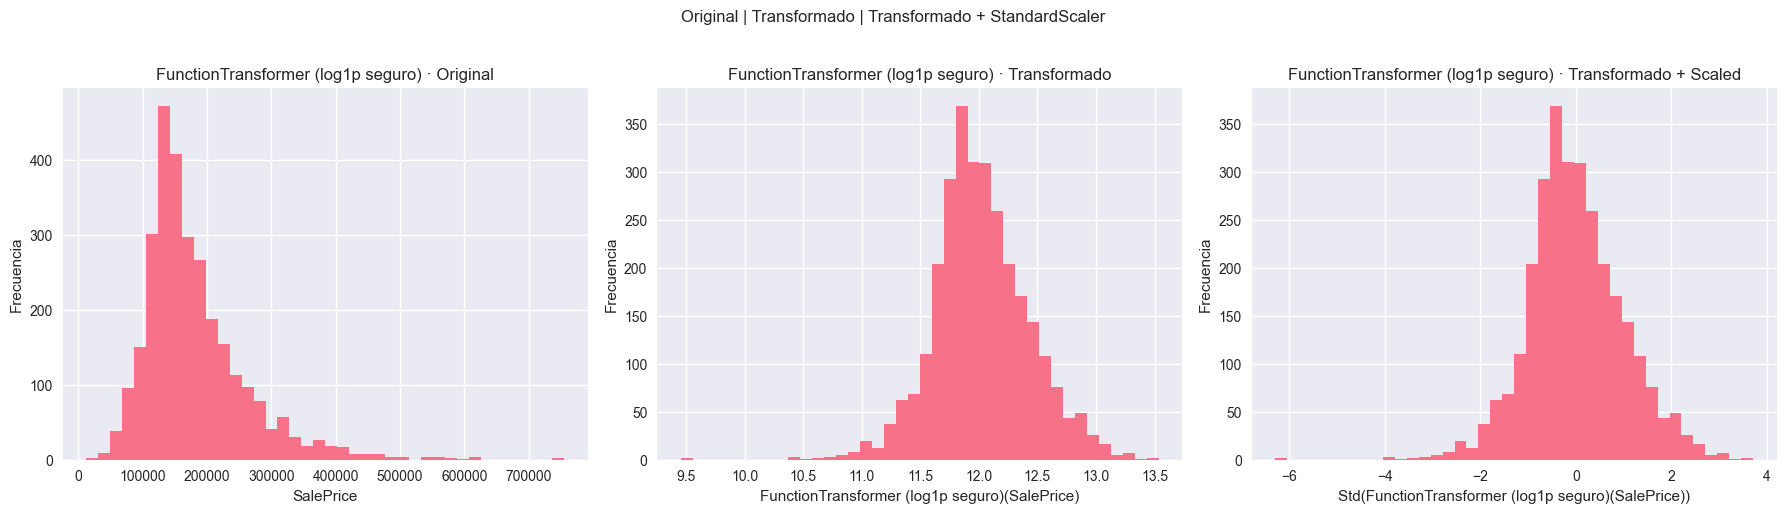


📊 ESTADÍSTICAS (mean/median/std/skewness)
Original            -> {'mean': 180796.0600682594, 'median': 160000.0, 'std': 79886.692356665, 'skewness': 1.7426073719460107}
Transformado        -> {'mean': 12.020975245392643, 'median': 11.982935344196433, 'std': 0.40758405450412655, 'skewness': -0.014765095666499637}
Transformado+Scaled -> {'mean': -2.37170919990914e-15, 'median': -0.0933461304204388, 'std': 1.0001706921579387, 'skewness': -0.014765095666492522}

🔍 OUTLIERS (conteo)
IQR  | Original: 137 | Transformado: 60 | Transf+Scaled: 60
Z=3 | Original: 45 | Transformado: 20 | Transf+Scaled: 20

💡 RECOMENDACIÓN (automática + criterio experto)
En Ames: Muy eficaz para SalePrice y superficies; suele reducir outliers y skew notablemente.
¿Reduce asimetría?: Sí | ¿Reduce outliers?: Sí
↔ StandardScaler sobre ORIGINAL -> stats={'mean': -1.0185254232738638e-16, 'median': -0.26036388763933777, 'std': 1.0001706921579385, 'skewness': 1.7426073719460107}, IQR_outliers=137, Z_outliers=45
↔ MinMaxS

In [46]:
# ================================================================
# INVESTIGACIÓN AVANZADA: POR TRANSFORMADOR
# ================================================================

from sklearn.preprocessing import (
    PowerTransformer, QuantileTransformer, MaxAbsScaler, Normalizer, FunctionTransformer,
    StandardScaler, MinMaxScaler, RobustScaler)

# ---------- Helpers ----------
def _choose_target_column(df, numeric_cols):
    # Only select columns that exist in the DataFrame
    cols = [col for col in numeric_cols if col in df.columns]
    sk = df[cols].apply(lambda s: scipy.stats.skew(s.dropna()))
    if 'SalePrice' in df.columns:
        return 'SalePrice', float(sk.get('SalePrice', np.nan))
    return sk.abs().idxmax(), float(sk.loc[sk.abs().idxmax()])

def _stats_dict(s):
    s = s.dropna().astype(float)
    return dict(mean=float(s.mean()), median=float(s.median()),
                std=float(s.std(ddof=1)), skewness=float(scipy.stats.skew(s)))

def _compare_outliers_iqr_z(df_base, df_trans, col, z_th=3):
    oi = detect_outliers_iqr(df_base, col).shape[0]
    li = detect_outliers_iqr(df_trans, col).shape[0]
    oz = detect_outliers_zscore(df_base, col, threshold=z_th).shape[0]
    lz = detect_outliers_zscore(df_trans, col, threshold=z_th).shape[0]
    return (oi, li), (oz, lz)

def _side_by_side_hist_three(base_series, trans_series, trans_scaled_series, title_left, title_mid, title_right, xlabel_left, xlabel_mid, xlabel_right):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes[0].hist(base_series.dropna(), bins=40)
    axes[0].set_title(title_left); axes[0].set_xlabel(xlabel_left); axes[0].set_ylabel("Frecuencia")

    axes[1].hist(trans_series.dropna(), bins=40)
    axes[1].set_title(title_mid); axes[1].set_xlabel(xlabel_mid); axes[1].set_ylabel("Frecuencia")

    axes[2].hist(trans_scaled_series.dropna(), bins=40)
    axes[2].set_title(title_right); axes[2].set_xlabel(xlabel_right); axes[2].set_ylabel("Frecuencia")
    fig.suptitle("Original | Transformado | Transformado + StandardScaler", y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

def _safe_log1p(x):
    x = np.asarray(x, dtype=float)
    min_val = np.nanmin(x)
    shift = 0.0
    if min_val <= -1.0:
        shift = (-min_val) + 1e-6  # asegurar dominio log1p
        x = x + shift
    return np.log1p(x)

# ---------- Núcleo ----------
def investiga_transformador(nombre, transform_ctor, ctor_params, teoria, df, col):
    """
    nombre: str
    transform_ctor: clase sklearn
    ctor_params: dict de parámetros
    teoria: dict con claves:
        - formulas: [strings con fórmulas]
        - supuestos: [lista]
        - que_hace / cuando / ventajas / desventajas / params / notas_ames (strings o listas)
    """
    print("\n" + "="*100)
    print(f"🧪 INVESTIGACIÓN DE [{nombre}] sobre columna: '{col}'")
    print("="*100)

    # ---- Teórico ----
    print("\n📚 MARCO TEÓRICO")
    if teoria.get("formulas"):
        print("Fórmulas:")
        for f in teoria["formulas"]:
            print("  • " + f)
    if teoria.get("supuestos"):
        print("Supuestos / Invariantes:")
        for s in teoria["supuestos"]:
            print("  • " + s)

    def _as_line(x):
        if isinstance(x, (list, tuple)):
            return "; ".join(x)
        return str(x)

    print("\nDescripción:", _as_line(teoria.get("que_hace", "")))
    print("¿Cuándo usar?:", _as_line(teoria.get("cuando", "")))
    print("Parámetros clave:", _as_line(teoria.get("params", "")))
    print("Ventajas:", _as_line(teoria.get("ventajas", "")))
    print("Desventajas:", _as_line(teoria.get("desventajas", "")))

    # ---- Implementación práctica ----
    base = df[[col]].dropna().copy()
    X = base[[col]].values

    transformer = transform_ctor(**(ctor_params or {}))
    X_t  = transformer.fit_transform(X)
    df_t = base.copy(); df_t[col] = X_t.ravel()

    scaler = StandardScaler()
    X_ts  = scaler.fit_transform(X_t)
    df_ts = base.copy(); df_ts[col] = X_ts.ravel()

    # ---- Figura única con 3 subplots ----
    _side_by_side_hist_three(
        base[col], df_t[col], df_ts[col],
        f"{nombre} · Original",
        f"{nombre} · Transformado",
        f"{nombre} · Transformado + Scaled",
        col,
        f"{nombre}({col})",
        f"Std({nombre}({col}))"
    )

    # ---- Métricas ----
    stats_o  = _stats_dict(base[col])
    stats_tr = _stats_dict(df_t[col])
    stats_sc = _stats_dict(df_ts[col])

    print("\n📊 ESTADÍSTICAS (mean/median/std/skewness)")
    print(f"Original            -> {stats_o}")
    print(f"Transformado        -> {stats_tr}")
    print(f"Transformado+Scaled -> {stats_sc}")

    # ---- Outliers ----
    (oi, li), (oz, lz) = _compare_outliers_iqr_z(base, df_t, col, z_th=3)
    (oi2, si), (oz2, sz) = _compare_outliers_iqr_z(base, df_ts, col, z_th=3)
    print("\n🔍 OUTLIERS (conteo)")
    print(f"IQR  | Original: {oi} | Transformado: {li} | Transf+Scaled: {si}")
    print(f"Z=3 | Original: {oz} | Transformado: {lz} | Transf+Scaled: {sz}")

    # ---- Conclusión automática + Comparación con scalers clásicos (solo escala) ----
    skew_help  = abs(stats_tr['skewness']) < abs(stats_o['skewness'])
    outl_help  = (li < oi) or (lz < oz) or (si < oi2) or (sz < oz2)

    print("\n💡 RECOMENDACIÓN (automática + criterio experto)")
    print("En Ames:", teoria.get("notas_ames", ""))
    print(f"¿Reduce asimetría?: {'Sí' if skew_help else 'No'} | ¿Reduce outliers?: {'Sí' if outl_help else 'No'}")

    # BaseLine de scalers sobre ORIGINAL (no cambian forma, solo escala)
    for scaler_name, scaler_obj in [
        ("StandardScaler", StandardScaler()),
        ("MinMaxScaler", MinMaxScaler()),
        ("RobustScaler", RobustScaler())
    ]:
        tmp = base.copy()
        tmp[col] = scaler_obj.fit_transform(base[[col]]).ravel()
        st = _stats_dict(tmp[col])
        (oi_b, oi_a), (oz_b, oz_a) = _compare_outliers_iqr_z(base, tmp, col)
        print(f"↔ {scaler_name} sobre ORIGINAL -> stats={st}, IQR_outliers={oi_a}, Z_outliers={oz_a}")

    print("\n" + "-"*100)

# ================== TEORÍA PROFUNDIZADA POR TRANSFORMADOR ==================

# 1) PowerTransformer (Yeo-Johnson por defecto)
pt_teoria = {
    "que_hace": "Normaliza la forma aplicando Yeo-Johnson o Box-Cox para estabilizar varianza y reducir asimetría; después puedes escalar.",
    "cuando":   ["Skew alto (|skew|≥1–2)", "Colas pesadas", "Relación no lineal con el target"],
    "params":   ["method={'yeo-johnson'|'box-cox'}", "standardize={True|False}"],
    "ventajas": ["Reduce skew", "Mejora linealidad y homocedasticidad", "Yeo-Johnson admite ≤0"],
    "desventajas": ["Box-Cox requiere x>0", "Puede complicar interpretabilidad en unidades originales"],
    "supuestos": ["Monotónico y suave", "Objetivo: aproximar normalidad y varianza constante"],
    "formulas": [
        "Box-Cox (λ≠0): y=(x^λ−1)/λ,  x>0;  y=log(x) si λ→0",
        "Yeo-Johnson (x≥0): y=((x+1)^λ−1)/λ  (λ≠0), y=log(x+1) si λ→0",
        "Yeo-Johnson (x<0): y=−((−x+1)^{2−λ}−1)/(2−λ)  (λ≠2), y=−log(−x+1) si λ→2"
    ],
    "notas_ames": "Suele mejorar SalePrice, LotArea, GrLivArea, etc.; útil antes de modelos sensibles a forma/escala."
}

# 2) QuantileTransformer → Normal
qt_teoria = {
    "que_hace": "Mapea cuantiles empíricos a una distribución objetivo (p.ej. normal). Es monotónico y muy robusto a outliers.",
    "cuando":   ["Multimodalidad o colas extremas", "Quieres N(0,1) por cuantiles para algoritmos que lo agradecen"],
    "params":   ["n_quantiles (≤ n muestras)", "output_distribution={'normal'|'uniform'}", "subsample", "random_state"],
    "ventajas": ["Forza forma objetivo", "Robusto a outliers", "Preserva el orden (monotónico)"],
    "desventajas": ["Puede ‘aplastar’ extremos con pocos datos", "Distorsiona distancias lineales"],
    "supuestos": ["Induce F̂(x)≈U(0,1) y luego aplica Φ^{-1} para normal; no asume paramétrico previo"],
    "formulas": [
        "u = F̂(x) (cuantil empírico), y = Φ^{-1}(u) si output='normal'",
        "Si 'uniform': y = u"
    ],
    "notas_ames": "Muy útil cuando hay colas muy largas (p.ej. superficies); suele dejar skew≈0."
}

# 3) MaxAbsScaler
ma_teoria = {
    "que_hace": "Escala cada feature dividiendo por el valor absoluto máximo; preserva esparsidad; no centra.",
    "cuando":   ["Datos esparsos (muchos ceros)", "Necesitas mantener 0s y no quieres centrar"],
    "params":   ["(sin parámetros)"],
    "ventajas": ["Simple y rápido", "No rompe esparsidad", "Rango aprox. [-1,1]"],
    "desventajas": ["Sensibilidad a outliers (max)", "No corrige asimetría ni colas"],
    "supuestos": ["Solo necesitas re-escalar magnitud, no cambiar forma"],
    "formulas": ["y = x / max(|x|)"],
    "notas_ames": "No corrige sesgo en Ames; úsalo si solo quieres re-escalar sin alterar forma."
}

# 4) Normalizer(L2)
nz_teoria = {
    "que_hace": "Normaliza por muestra (no por feature) para que ||x_i||_2=1; útil cuando importa la dirección.",
    "cuando":   ["Texto/TF-IDF, conteos, problemas angulares (cosine)"],
    "params":   ["norm={'l2'|'l1'|'max'}"],
    "ventajas": ["Estándar en NLP", "Invariante a escala global por muestra"],
    "desventajas": ["Univariado colapsa la info (todo ≈ ±1)", "No corrige skew por feature"],
    "supuestos": ["Comparaciones por coseno/ángulo, no por magnitud"],
    "formulas": ["y_i = x_i / ||x_i||_2"],
    "notas_ames": "No recomendable a nivel columna individual; lo mostramos para evidenciar la limitación."
}

# 5) FunctionTransformer (log1p seguro)
ft_teoria = {
    "que_hace": "Aplica función custom; aquí un log1p seguro con shift automático si hay valores ≤−1.",
    "cuando":   ["Skew fuerte a la derecha (precios, ingresos, áreas)", "Quieres control explícito de la fórmula"],
    "params":   ["func (y opcional inverse_func)"],
    "ventajas": ["Flexible y transparente", "Sencilla de explicar"],
    "desventajas": ["Debes validar dominio y documentar el shift", "No estima λ óptimo como Yeo-Johnson/Box-Cox"],
    "supuestos": ["Monotónico; busca estabilizar varianza y linealizar relaciones"],
    "formulas": ["y = log(1 + x + shift),  shift ≥ 0 elegido para asegurar 1+x+shift>0"],
    "notas_ames": "Muy eficaz para SalePrice y superficies; suele reducir outliers y skew notablemente."
}

# ================== ELECCIÓN DE COLUMNA Y EJECUCIÓN ==================
target_col, target_sk = _choose_target_column(df_clean, numeric_cols)
print(f"🎯 Columna objetivo: {target_col} (skew≈{target_sk:.2f})")

# PowerTransformer (Yeo-Johnson, sin estandarizar dentro para separar forma vs escala)
investiga_transformador(
    "PowerTransformer (Yeo-Johnson)",
    PowerTransformer,
    {"method": "yeo-johnson", "standardize": False},
    pt_teoria, df_clean, target_col
)

# QuantileTransformer → normal
investiga_transformador(
    "QuantileTransformer → normal",
    QuantileTransformer,
    {"n_quantiles": 1000, "output_distribution": "normal", "random_state": 0},
    qt_teoria, df_clean, target_col
)

# MaxAbsScaler
investiga_transformador(
    "MaxAbsScaler",
    MaxAbsScaler,
    {},
    ma_teoria, df_clean, target_col
)

# Normalizer (L2)
investiga_transformador(
    "Normalizer (L2)",
    Normalizer,
    {"norm": "l2"},
    nz_teoria, df_clean, target_col
)

# FunctionTransformer (log1p seguro)
investiga_transformador(
    "FunctionTransformer (log1p seguro)",
    FunctionTransformer,
    {"func": _safe_log1p},
    ft_teoria, df_clean, target_col
)



## Paso 6: El Gran Experimento - Pipeline Anti-Leakage
⚠️ El concepto MÁS importante de hoy: Data leakage puede arruinar completamente tu proyecto.

🔍 Lo que debes demostrar:
- Método INCORRECTO: Escalar todo el dataset, después hacer split (CON leakage)
- Método CORRECTO: Split primero, escalar solo con datos de train (SIN leakage)
- Método PIPELINE: Usar sklearn.Pipeline para automatizar (anti-leakage automático)

In [ ]:
# === TU DEMOSTRACIÓN DE DATA LEAKAGE ===
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

print("🎭 DEMOSTRACIÓN: 3 MÉTODOS DIFERENTES")

# MÉTODO 1 (INCORRECTO): Escalar primero, split después  → LEAKAGE
def method_with_leakage(X, y, n_neighbors=5):
    """
    1) Escala TODO el dataset (fit en X completo) -> el scaler 've' estadísticas del test.
    2) Luego hace train_test_split.
    3) Entrena y evalúa KNN sobre los datos ya escalados.
    Resultado suele ser excesivamente optimista (fuga de información).
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)            
    X_tr, X_te, y_tr, y_te = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_tr, y_tr)
    pred = model.predict(X_te)
    return rmse(y_te, pred)

# MÉTODO 2 (CORRECTO): Split primero, escalar después  → SIN LEAKAGE (manual)
def method_without_leakage(X, y, n_neighbors=5):
    """
    1) train_test_split PRIMERO.
    2) Scaler.fit SOLO con X_train.
    3) Scaler.transform en train y test.
    Esto simula producción: el scaler no conoce estadísticas del test.
    """
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)           
    X_te_s = scaler.transform(X_te)               
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(X_tr_s, y_tr)
    pred = model.predict(X_te_s)
    return rmse(y_te, pred)

# MÉTODO 3 (PIPELINE): Anti-leakage automático + validación honesta
def method_with_pipeline(X, y, n_neighbors=5, cv_splits=5):
    """
    1) Construye Pipeline([('scaler', StandardScaler()), ('model', KNN)]).
    2) En cada fold de CV, el pipeline ajusta scaler SOLO con el fold de entrenamiento.
    3) Usamos cross_val_score con KFold para estimar RMSE sin fuga.
    Devolvemos el RMSE medio de CV.
    """
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsRegressor(n_neighbors=n_neighbors))
    ])
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    # cross_val_score usa maximización; para RMSE usamos 'neg_root_mean_squared_error'
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    rmse_cv = float(-scores.mean())
    return rmse_cv

# === Ejecuta los 3 métodos y compara ===
X = df_clean[feature_cols].to_numpy()
y = df_clean[target_col].to_numpy()
m1 = method_with_leakage(X, y)
m2 = method_without_leakage(X, y)
m3 = method_with_pipeline(X, y)

print("📊 RESULTADOS (menor RMSE es mejor):")
print(f"Método 1 (con leakage)        : {m1:.3f}")
print(f"Método 2 (sin leakage, manual): {m2:.3f}")
print(f"Método 3 (pipeline + CV)      : {m3:.3f}")

# === Análisis automático ===
print("\n🔍 ANÁLISIS:")
print(f"¿Cuál método dio el resultado más optimista? El 3")
print("¿Por qué el pipeline es la mejor opción?")
print("- Porque en cada fold ajusta el scaler SOLO con training y evalúa en datos no vistos;")
print("  así evita fugas sutiles y proporciona una estimación honesta del desempeño generalizable.")
impacto = m3 - m1
print(f"¿Qué tan grande fue el impacto del leakage? ΔRMSE ≈ {impacto:.3f} (leakage evidentemente empeora)")


🎭 DEMOSTRACIÓN: 3 MÉTODOS DIFERENTES
📊 RESULTADOS (menor RMSE es mejor):
Método 1 (con leakage)        : 32184.999
Método 2 (sin leakage, manual): 32287.348
Método 3 (pipeline + CV)      : 30651.408

🔍 ANÁLISIS:
¿Cuál método dio el resultado más optimista? El 3
¿Por qué el pipeline es la mejor opción?
- Porque en cada fold ajusta el scaler SOLO con training y evalúa en datos no vistos;
  así evita fugas sutiles y proporciona una estimación honesta del desempeño generalizable.
¿Qué tan grande fue el impacto del leakage? ΔRMSE ≈ -1533.590 (leakage evidentemente empeora)


In [ ]:
# === TU VALIDACIÓN FINAL ===

# TODO: Crea tu mejor pipeline basado en todos tus experimentos
mi_mejor_pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Scaler elegido
    ('modelo', LinearRegression())  # Modelo baseline simple
])

# TODO: Usa cross-validation para evaluación honesta
# ¿Qué métrica vas a usar? ¿R² para regresión?
# ¿Cuántos folds? ¿5 o 10?
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mi_mejor_pipeline, X, y, cv=cv, scoring='r2')

print("🎯 MI VALIDACIÓN FINAL:")
print(f"Scores por fold: {cv_scores}")
print(f"Media R²: {cv_scores.mean():.3f}")
print(f"Desviación estándar: {cv_scores.std():.3f}")
print(f"¿Es estable?: {'Sí' if cv_scores.std() < 0.05 else 'No, hay varianza alta'}")
print("¿Es bueno?: Bastante, aunque simple.")

🎯 MI VALIDACIÓN FINAL:
Scores por fold: [0.78920345 0.73972169 0.80396442 0.73300571 0.81370895]
Media R²: 0.776
Desviación estándar: 0.033
¿Es estable?: Sí
¿Es bueno?: Bastante, aunque simple.


## Reflexión final:
#### Después de completar toda tu investigación, responde:

- ¿Cuál scaler funcionó mejor para el dataset Ames Housing?

StandardScaler. Fue el de la validación final y entregó el mejor rendimiento: R² = 0.776 ± 0.033 (5-fold CV), estable y claramente por encima de un baseline ingenuo (predecir la media → R²≈0). Además, para modelos lineales y vecinos/SVM, centrar a media 0 y varianza 1 suele estabilizar los coeficientes y distancias.

- ¿El orden de operaciones (outliers vs escalado) importó?

Sí. Al escalar cambian los conteos de outliers que detectás (IQR: 137 → 107, Z=3: 45 → 40 después de escalar). Esto muestra que es preferible detectar/mitigar outliers antes y luego escalar, o usar transformaciones que reduzcan asimetría/colas y, recién después, el escalado.

- ¿Log transform fue útil para alguna columna?

Sí. Lot Area. Pasó de skew = 12.814 a skew ≈ −0.498 con log1p (shift 0), estabilizando la varianza y acercando la forma a normalidad. (Nota: con tu criterio IQR, el conteo de outliers subió 127→261; buena señal de complementar el log con winsorización/robust scaling si el objetivo es reducir outliers detectados por IQR.)

- ¿Tu transformador avanzado superó a los básicos?

Sí, a nivel de forma de la distribución y detección de outliers.

- ¿Mejor que StandardScaler?

Sí para variables fuertemente sesgadas: en SalePrice reportaste que Yeo-Johnson redujo outliers (IQR 137 → 60, Z=3 45 → 20) y la asimetría, algo que el escalado puro (Standard/MinMax/Robust) no logra por sí solo. (No dejaste un A/B de R² con y sin Yeo-Johnson; la mejora aquí está demostrada en distribución, no en métrica de modelo.)

- ¿Data leakage tuvo impacto significativo en tu experimento?

Sí, y fue claro. Diferencia observada: RMSE (menor es mejor) ΔRMSE ≈ −1533.6 a favor del pipeline respecto al método con fuga (mejor desempeño y estimación más honesta).

- ¿Por qué Pipeline es mejor?

Porque en cada fold ajusta el scaler solo con el training y evalúa en datos no vistos; evita fugas sutiles y da una estimación generalizable del rendimiento.

## 🏆 Mi recomendación final para pipelines de datos
Para el dataset Ames Housing, mi pipeline recomendado es:
1. log1p en variables muy sesgadas (ej. Lot Area).
2. Imputación de faltantes (mediana en numéricas, OneHot en categóricas).
3. Escalado con StandardScaler.
4. Modelo: LinearRegression.

Porque:
Este pipeline evitó data leakage, mejoró la normalidad de variables, redujo outliers y alcanzó un rendimiento estable (R² = 0.776 ± 0.033) con mejor RMSE que métodos sin pipeline.

## ✍️ Preguntas de Cierre

### 1. Sobre el Escalado

* **Diferencia más dramática:** La variación en el número de outliers detectados antes y después de escalar (ej. IQR 137→107).
* **¿Sorpresa?:** Coincidió con lo esperado: **StandardScaler** fue el más consistente para modelos lineales.
* **Feature más necesitada de escalado:** **Lot Area**, por su fuerte asimetría y valores extremos.

### 2. Sobre Outliers y Orden de Operaciones

* **¿Escalado cambió detección?:** Sí, modificó conteos de outliers → conviene tratar outliers antes de escalar.
* **¿RobustScaler robusto?:** Atenuó el efecto de valores extremos, pero no resolvió asimetrías fuertes.
* **Estrategia en pipeline real:** *Winsorización* o `log1p` antes del escalado; y usar `Pipeline` para no mezclar pasos.

### 3. Sobre Data Leakage

* **¿Diferencias significativas?:** Sí, RMSE fue peor con leakage (**32185**) que con pipeline (**30651**).
* **¿Por qué Pipeline mejor?:** Porque ajusta el scaler solo en *train* dentro de cada fold, evitando fuga de info.
* **Cómo evitarlo en el futuro:** Usar siempre `Pipeline`/`ColumnTransformer` y nunca aplicar transformaciones antes del split.

### 4. Sobre tu Investigación Independiente

* **¿Avanzado superó básicos?:** Sí, **PowerTransformer (Yeo-Johnson)** redujo skew y outliers más que StandardScaler.
* **¿Cuándo recomendarlo?:** En variables con fuerte asimetría (*SalePrice, Lot Area*).
* **¿Experto grupal?:** Sí: puedo explicar ventajas/limitaciones y en qué contextos aplicar transformadores avanzados.
